# ENGY 604 Part B: Multi-Period Scheduling with Pyomo
The Pyomo optimization problem solution for Part B - Multi-period scheduling over 24 hours

## Section 0 – Environment Setup (Google Colab)
Run this section only if you're using Google Colab. It will install GLPK solver and Pyomo.

In [20]:
# Optional Google Colab Setup - Install GLPK and Pyomo
try:
    import google.colab
    IN_COLAB = True
    print("Running in Google Colab environment")
    print("Installing required packages...")

    # Install GLPK solver
    !apt-get install -y -qq glpk-utils

    # Install Pyomo
    !pip install -q pyomo

    print("✓ GLPK solver installed successfully")
    print("✓ Pyomo installed successfully")
    print("\nYou can now run the rest of the notebook!")

except ImportError:
    IN_COLAB = False
    print("Not running in Google Colab - skipping installation")
    print("Assuming local environment with GLPK already installed")

Not running in Google Colab - skipping installation
Assuming local environment with GLPK already installed


## Section 1 – Setup

### Time-Varying Lighting Demand Data
Hourly lighting demand for the supermarket (in kW)

In [21]:
# Inline lighting demand data (kW) for each hour of the day
lighting_demand_dict = {
    1: 91,
    2: 88,
    3: 87,
    4: 88,
    5: 92,
    6: 101,
    7: 112,
    8: 123,
    9: 132,
    10: 141,
    11: 150,
    12: 155,
    13: 159,
    14: 163,
    15: 165,
    16: 166,
    17: 168,
    18: 176,
    19: 183,
    20: 180,
    21: 172,
    22: 165,
    23: 156,
    24: 147,
}

print(f"Lighting demand loaded for {len(lighting_demand_dict)} time periods")
print(f"Range: {min(lighting_demand_dict.values())} - {max(lighting_demand_dict.values())} kW")

Lighting demand loaded for 24 time periods
Range: 87 - 183 kW


In [22]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

from pyomo.environ import (
    ConcreteModel,
    Constraint,
    NonNegativeReals,
    Objective,
    Param,
    Set,
    SolverFactory,
    Var,
    minimize,
    value,
)

# Operating horizon (1 day = 24 hours)
H_day = 24
delta_t = 1  # Duration of each time period in hours

# Resource data from Table 3 (prices in $/GJ)
resource_data = {
    "Natural Gas": {"price_per_GJ": 8.89},
    "Biomass": {"price_per_GJ": 9.72},
    "Grid Electricity": {"price_per_GJ": 36.11},
}

# Generator data from Table 2
generator_data = {
    "BioST": {
        "opex_per_kw_year": 15.0,
        "eta_elec": 0.68,
        "eta_heat": 0.0,
        "installed_capacity": 0.0,  # Not installed
    },
    "CHP": {
        "opex_per_kw_year": 15.0,
        "eta_elec": 0.44,
        "eta_heat": 0.28,
        "installed_capacity": 800.0,  # From Part A solution
    },
    "SolarPV": {
        "opex_per_kw_year": 500.0,
        "eta_elec": 0.09,
        "eta_heat": 0.0,
        "installed_capacity": 0.0,  # Not installed
    },
    "Wind": {
        "opex_per_kw_year": 1200.0,
        "eta_elec": 0.22,
        "eta_heat": 0.0,
        "installed_capacity": 0.0,  # Not installed
    },
}

# Conversion device data from Table 1
converter_data = {
    "Refrigerator": {"demand_kw": 1000.0, "eta": 3.0},  # COP
    "LED": {"demand_kw": None, "eta": 0.80},  # Time-varying (defined in previous cell)
    "Heater": {"demand_kw": 100.0, "eta": 0.85},
}

# Sets for later reference
time_periods = list(range(1, 25))  # T = {1, 2, ..., 24}
resources = list(resource_data.keys())
generators = list(generator_data.keys())

# Mapping between generators and their primary resources
fuel_links = {
    "BioST": "Biomass",
    "CHP": "Natural Gas",
}

grid_resource = "Grid Electricity"
chp_generator = "CHP"

# Solver configuration
solver_name = "glpk"

# Check if running in Google Colab
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

# Configure solver based on environment
if IN_COLAB:
    # Google Colab - GLPK is installed via apt-get and available in PATH
    print("Configuring solver for Google Colab environment...")
    solver = SolverFactory(solver_name)
    print("✓ Using system GLPK solver")
else:
    # Local environment - Check for Windows executable first
    print("Configuring solver for local environment...")

    # Try Windows-specific path first
    windows_executable = Path(r"C:\glpk-4.65\w64\glpsol.exe")

    if windows_executable.exists():
        solver = SolverFactory(solver_name, executable=str(windows_executable))
        print(f"✓ Using GLPK from: {windows_executable}")
    else:
        # Try system PATH (Linux/Mac or Windows with GLPK in PATH)
        solver = SolverFactory(solver_name)
        print("✓ Using GLPK from system PATH")

# Verify solver is available
if not solver.available(exception_flag=False):
    print("\n" + "="*70)
    print("ERROR: GLPK solver is not available!")
    print("="*70)
    if IN_COLAB:
        print("Run the installation cell above (Section 0) first.")
    else:
        print("Please install GLPK:")
        print("  • Windows: Download from https://www.gnu.org/software/glpk/")
        print("  • Linux: sudo apt-get install glpk-utils")
        print("  • Mac: brew install glpk")
    print("="*70)
    raise RuntimeError("GLPK solver is not available.")
else:
    print(f"✓ Solver '{solver_name}' is ready to use")

print("\n" + "="*70)
print("Setup complete!")
print(f"Time periods: {len(time_periods)}")
print(f"Lighting demand range: {min(lighting_demand_dict.values())} - {max(lighting_demand_dict.values())} kW")
print(f"Installed generator: CHP with {generator_data['CHP']['installed_capacity']} kW capacity")

Configuring solver for local environment...
✓ Using GLPK from: C:\glpk-4.65\w64\glpsol.exe
✓ Solver 'glpk' is ready to use

Setup complete!
Time periods: 24
Lighting demand range: 87 - 183 kW
Installed generator: CHP with 800.0 kW capacity


## Section 2 – Intermediate Parameter Calculations
Convert units from base parameters to the formats needed for the multi-period scheduling model.

In [23]:
# Resource Price Conversions ($/GJ to $/kWh)
# 1 GJ = 277.78 kWh (or divide by 3600 since 1 kWh = 3.6 MJ)
resource_price_kwh = {
    r: vals["price_per_GJ"] / 277.78 for r, vals in resource_data.items()
}

# Generator OPEX Conversions ($/kW-year to $/kWh)
# Divide by 8760 hours/year
generator_opex_kwh = {
    g: vals["opex_per_kw_year"] / 8760 for g, vals in generator_data.items()
}

# Calculate time-varying electrical and heat demands
elec_demand_t = {}
heat_demand_t = {}

for t in time_periods:
    # Electrical demand = Refrigerator input + LED input
    refrig_input = converter_data["Refrigerator"]["demand_kw"] / converter_data["Refrigerator"]["eta"]
    led_input = lighting_demand_dict[t] / converter_data["LED"]["eta"]
    elec_demand_t[t] = refrig_input + led_input

    # Heat demand = Heater input (constant)
    heat_demand_t[t] = converter_data["Heater"]["demand_kw"] / converter_data["Heater"]["eta"]

print("Resource prices ($/kWh):")
for r, val in resource_price_kwh.items():
    print(f"  {r}: {val:.5f}")

print("\nGenerator OPEX ($/kWh):")
for g, val in generator_opex_kwh.items():
    print(f"  {g}: {val:.5f}")

print("\nElectrical demand range: {:.2f} - {:.2f} kW".format(
    min(elec_demand_t.values()), max(elec_demand_t.values())
))
print(f"Heat demand (constant): {heat_demand_t[1]:.2f} kW")

# Display sample demands
print("\nSample electrical demands:")
for t in [1, 12, 19, 24]:
    print(f"  t={t}: {elec_demand_t[t]:.2f} kW (lighting: {lighting_demand_dict[t]} kW)")

Resource prices ($/kWh):
  Natural Gas: 0.03200
  Biomass: 0.03499
  Grid Electricity: 0.12999

Generator OPEX ($/kWh):
  BioST: 0.00171
  CHP: 0.00171
  SolarPV: 0.05708
  Wind: 0.13699

Electrical demand range: 442.08 - 562.08 kW
Heat demand (constant): 117.65 kW

Sample electrical demands:
  t=1: 447.08 kW (lighting: 91 kW)
  t=12: 527.08 kW (lighting: 155 kW)
  t=19: 562.08 kW (lighting: 183 kW)
  t=24: 517.08 kW (lighting: 147 kW)


## Section 3 – Pyomo Model Construction
Build the multi-period MILP with time-indexed decision variables and constraints.

In [24]:
def build_multiperiod_model():
    """Create a multi-period scheduling model for Part B."""
    model = ConcreteModel(name="PartB_MultiPeriod_Scheduling")

    # -------------------------
    # Sets
    # -------------------------
    model.T = Set(initialize=time_periods, ordered=True)  # Time periods
    model.G = Set(initialize=generators, ordered=True)    # Generators
    model.R = Set(initialize=resources, ordered=True)     # Resources

    # -------------------------
    # Parameters
    # -------------------------
    model.delta_t = Param(initialize=delta_t)  # Time step duration

    # Generator parameters
    model.opex = Param(model.G, initialize=generator_opex_kwh)
    model.eta_elec = Param(model.G, initialize={g: generator_data[g]["eta_elec"] for g in generators})
    model.eta_heat = Param(model.G, initialize={g: generator_data[g]["eta_heat"] for g in generators})
    model.C_installed = Param(model.G, initialize={g: generator_data[g]["installed_capacity"] for g in generators})

    # Resource parameters
    model.price = Param(model.R, initialize=resource_price_kwh)

    # Time-varying demands
    model.elec_demand = Param(model.T, initialize=elec_demand_t)
    model.heat_demand = Param(model.T, initialize=heat_demand_t)

    # -------------------------
    # Decision Variables (time-indexed)
    # -------------------------
    model.P_elec = Var(model.G, model.T, domain=NonNegativeReals)  # Electric power generation
    model.P_cons = Var(model.R, model.T, domain=NonNegativeReals)  # Resource consumption

    # -------------------------
    # Objective Function: Minimize Total Daily Operating Cost
    # -------------------------
    def objective_rule(m):
        # Generator operating costs
        gen_cost = sum(
            m.P_elec[g, t] * m.delta_t * m.opex[g]
            for g in m.G for t in m.T
        )

        # Resource (fuel) costs
        fuel_cost = sum(
            m.P_cons[r, t] * m.delta_t * m.price[r]
            for r in m.R for t in m.T
        )

        return gen_cost + fuel_cost

    model.obj = Objective(rule=objective_rule, sense=minimize)

    # -------------------------
    # Constraints
    # -------------------------

    # Electricity Balance (for each time period)
    def electricity_balance_rule(m, t):
        return sum(m.P_elec[g, t] for g in m.G) + m.P_cons[grid_resource, t] == m.elec_demand[t]

    model.electricity_balance = Constraint(model.T, rule=electricity_balance_rule)

    #  Heat Balance (for each time period)
    def heat_balance_rule(m, t):
        # Heat from CHP = P_CHP * (eta_heat / eta_elec)
        return m.P_elec[chp_generator, t] * (m.eta_heat[chp_generator] / m.eta_elec[chp_generator]) == m.heat_demand[t]

    model.heat_balance = Constraint(model.T, rule=heat_balance_rule)

    # Fuel Balance (for each time period and fuel-consuming generator)
    def fuel_balance_rule(m, g, t):
        resource = fuel_links.get(g)
        if resource is None:
            return Constraint.Skip
        return m.P_elec[g, t] == m.P_cons[resource, t] * m.eta_elec[g]

    model.fuel_balance = Constraint(model.G, model.T, rule=fuel_balance_rule)

    # Generation Output Limit (for each time period)
    def output_limit_rule(m, g, t):
        return m.P_elec[g, t] <= m.C_installed[g]

    model.output_limit = Constraint(model.G, model.T, rule=output_limit_rule)

    return model

print("Model construction function defined.")

Model construction function defined.


## Section 4 – Solve the Multi-Period Scheduling Problem
Solve the optimization problem to determine the optimal hourly dispatch.

In [25]:
# Build and solve the model
model = build_multiperiod_model()
results = solver.solve(model, tee=False)

print("=== Multi-Period Scheduling Solution ===")
print(f"Status: {results.solver.status}")
print(f"Termination: {results.solver.termination_condition}")
print(f"\nTotal Daily Operating Cost: ${value(model.obj):,.2f}")

# Calculate breakdown of costs
total_gen_cost = sum(
    value(model.P_elec[g, t]) * delta_t * generator_opex_kwh[g]
    for g in generators for t in time_periods
)
total_fuel_cost = sum(
    value(model.P_cons[r, t]) * delta_t * resource_price_kwh[r]
    for r in resources for t in time_periods
)

print(f"\nCost Breakdown:")
print(f"  Generator Operating Cost: ${total_gen_cost:,.2f}")
print(f"  Resource (Fuel) Cost: ${total_fuel_cost:,.2f}")

# Calculate total energy statistics
total_chp_generation = sum(value(model.P_elec["CHP", t]) * delta_t for t in time_periods)
total_grid_consumption = sum(value(model.P_cons["Grid Electricity", t]) * delta_t for t in time_periods)
total_natgas_consumption = sum(value(model.P_cons["Natural Gas", t]) * delta_t for t in time_periods)

print(f"\nDaily Energy Summary:")
print(f"  Total CHP Generation: {total_chp_generation:,.2f} kWh")
print(f"  Total Grid Electricity: {total_grid_consumption:,.2f} kWh")
print(f"  Total Natural Gas Consumption: {total_natgas_consumption:,.2f} kWh")

=== Multi-Period Scheduling Solution ===
Status: ok
Termination: optimal

Total Daily Operating Cost: $1,339.48

Cost Breakdown:
  Generator Operating Cost: $7.60
  Resource (Fuel) Cost: $1,331.88

Daily Energy Summary:
  Total CHP Generation: 4,436.97 kWh
  Total Grid Electricity: 7,763.03 kWh
  Total Natural Gas Consumption: 10,084.03 kWh


## Section 5 – Extract and Display Hourly Results

In [26]:
# Create detailed hourly results DataFrame
hourly_results = []

for t in time_periods:
    hourly_results.append({
        'Time Period': t,
        'Lighting Demand (kW)': lighting_demand_dict[t],
        'Total Elec Demand (kW)': elec_demand_t[t],
        'Heat Demand (kW)': heat_demand_t[t],
        'CHP Generation (kW)': value(model.P_elec['CHP', t]),
        'Grid Electricity (kW)': value(model.P_cons['Grid Electricity', t]),
        'Natural Gas (kW)': value(model.P_cons['Natural Gas', t]),
    })

df_hourly = pd.DataFrame(hourly_results)

# Display full table
print("\n=== Hourly Dispatch Schedule ===")
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', '{:.2f}'.format)
print(df_hourly.to_string(index=False))


=== Hourly Dispatch Schedule ===
 Time Period  Lighting Demand (kW)  Total Elec Demand (kW)  Heat Demand (kW)  CHP Generation (kW)  Grid Electricity (kW)  Natural Gas (kW)
           1                    91                  447.08            117.65               184.87                 262.21            420.17
           2                    88                  443.33            117.65               184.87                 258.46            420.17
           3                    87                  442.08            117.65               184.87                 257.21            420.17
           4                    88                  443.33            117.65               184.87                 258.46            420.17
           5                    92                  448.33            117.65               184.87                 263.46            420.17
           6                   101                  459.58            117.65               184.87                 274.71            

## Section 6 – Visualization
Plot the hourly dispatch schedule and demand profiles.

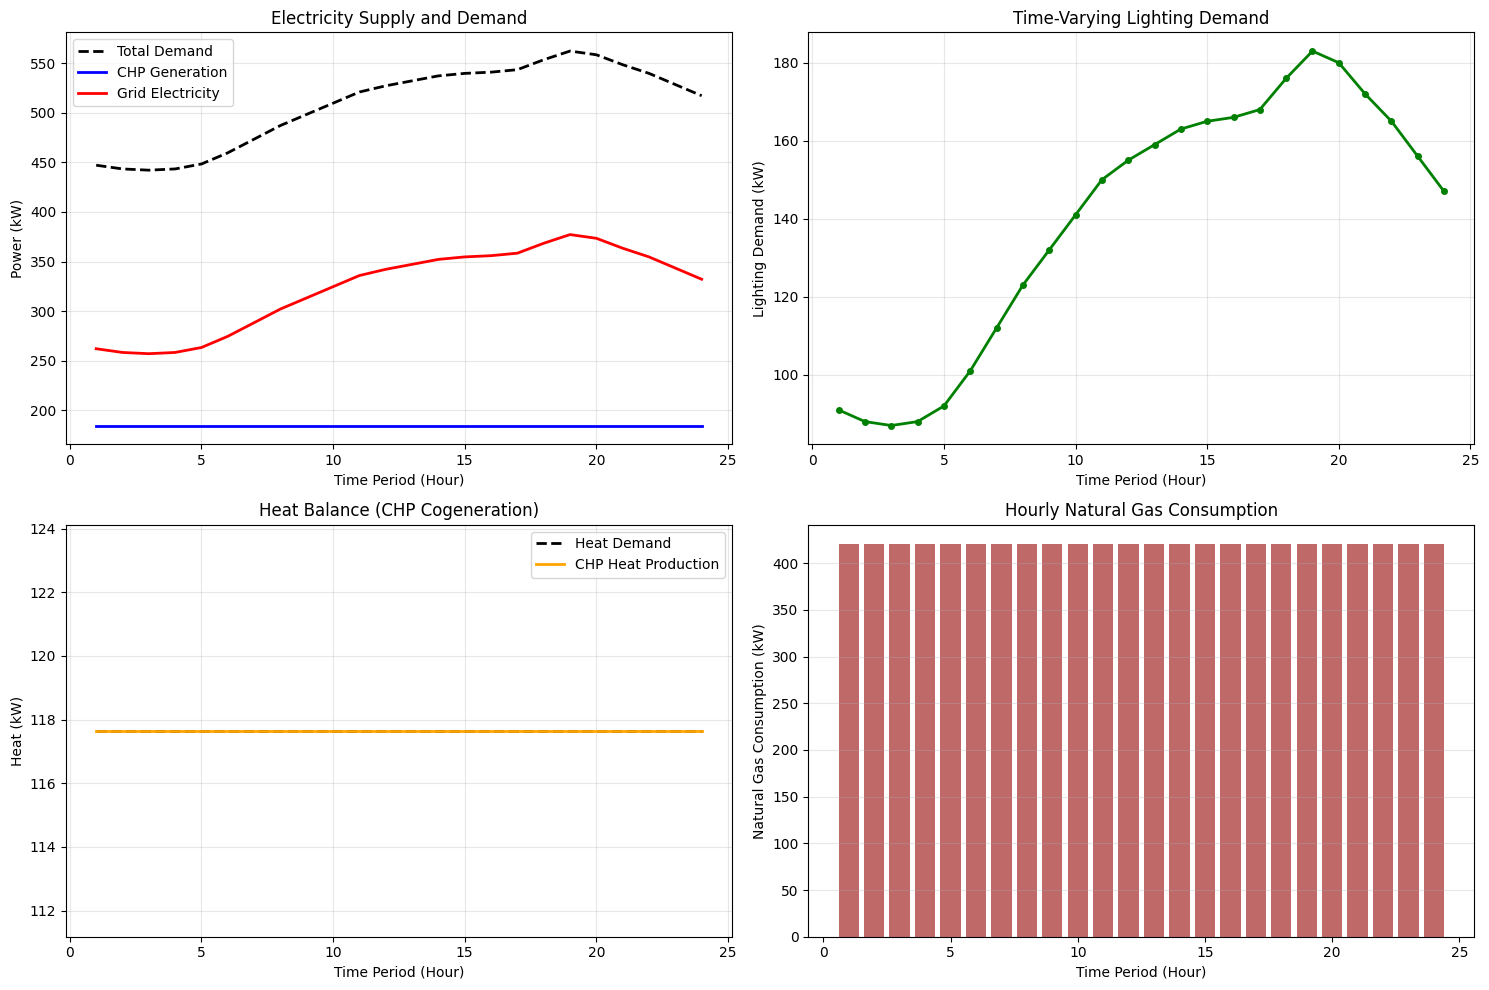


Visualization complete!


In [27]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Electricity Supply and Demand
ax1 = axes[0, 0]
ax1.plot(df_hourly['Time Period'], df_hourly['Total Elec Demand (kW)'],
         'k--', linewidth=2, label='Total Demand')
ax1.plot(df_hourly['Time Period'], df_hourly['CHP Generation (kW)'],
         'b-', linewidth=2, label='CHP Generation')
ax1.plot(df_hourly['Time Period'], df_hourly['Grid Electricity (kW)'],
         'r-', linewidth=2, label='Grid Electricity')
ax1.set_xlabel('Time Period (Hour)')
ax1.set_ylabel('Power (kW)')
ax1.set_title('Electricity Supply and Demand')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Lighting Demand Profile
ax2 = axes[0, 1]
ax2.plot(df_hourly['Time Period'], df_hourly['Lighting Demand (kW)'],
         'g-', linewidth=2, marker='o', markersize=4)
ax2.set_xlabel('Time Period (Hour)')
ax2.set_ylabel('Lighting Demand (kW)')
ax2.set_title('Time-Varying Lighting Demand')
ax2.grid(True, alpha=0.3)

# Plot 3: CHP Heat Production
ax3 = axes[1, 0]
ax3.plot(df_hourly['Time Period'], df_hourly['Heat Demand (kW)'],
         'k--', linewidth=2, label='Heat Demand')
ax3.plot(df_hourly['Time Period'], df_hourly['CHP Generation (kW)'] *
         (generator_data['CHP']['eta_heat'] / generator_data['CHP']['eta_elec']),
         'orange', linewidth=2, label='CHP Heat Production')
ax3.set_xlabel('Time Period (Hour)')
ax3.set_ylabel('Heat (kW)')
ax3.set_title('Heat Balance (CHP Cogeneration)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Natural Gas Consumption
ax4 = axes[1, 1]
ax4.bar(df_hourly['Time Period'], df_hourly['Natural Gas (kW)'],
        color='brown', alpha=0.7)
ax4.set_xlabel('Time Period (Hour)')
ax4.set_ylabel('Natural Gas Consumption (kW)')
ax4.set_title('Hourly Natural Gas Consumption')
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nVisualization complete!")

## Section 7 – Summary Statistics

In [28]:
# Calculate summary statistics
print("=== Summary Statistics ===")
print(f"\nElectrical Demand:")
print(f"  Minimum: {df_hourly['Total Elec Demand (kW)'].min():.2f} kW (Period {df_hourly['Total Elec Demand (kW)'].idxmin() + 1})")
print(f"  Maximum: {df_hourly['Total Elec Demand (kW)'].max():.2f} kW (Period {df_hourly['Total Elec Demand (kW)'].idxmax() + 1})")
print(f"  Average: {df_hourly['Total Elec Demand (kW)'].mean():.2f} kW")

print(f"\nCHP Generation:")
print(f"  Minimum: {df_hourly['CHP Generation (kW)'].min():.2f} kW")
print(f"  Maximum: {df_hourly['CHP Generation (kW)'].max():.2f} kW")
print(f"  Average: {df_hourly['CHP Generation (kW)'].mean():.2f} kW")
print(f"  Capacity Utilization: {(df_hourly['CHP Generation (kW)'].max() / generator_data['CHP']['installed_capacity']) * 100:.1f}%")

print(f"\nGrid Electricity:")
print(f"  Minimum: {df_hourly['Grid Electricity (kW)'].min():.2f} kW")
print(f"  Maximum: {df_hourly['Grid Electricity (kW)'].max():.2f} kW")
print(f"  Average: {df_hourly['Grid Electricity (kW)'].mean():.2f} kW")

# Calculate cost breakdown by hour
df_hourly['Hourly Cost ($)'] = (
    df_hourly['CHP Generation (kW)'] * delta_t * generator_opex_kwh['CHP'] +
    df_hourly['Grid Electricity (kW)'] * delta_t * resource_price_kwh['Grid Electricity'] +
    df_hourly['Natural Gas (kW)'] * delta_t * resource_price_kwh['Natural Gas']
)

print(f"\nHourly Operating Cost:")
print(f"  Minimum: ${df_hourly['Hourly Cost ($)'].min():.2f} (Period {df_hourly['Hourly Cost ($)'].idxmin() + 1})")
print(f"  Maximum: ${df_hourly['Hourly Cost ($)'].max():.2f} (Period {df_hourly['Hourly Cost ($)'].idxmax() + 1})")
print(f"  Average: ${df_hourly['Hourly Cost ($)'].mean():.2f}")
print(f"  Total Daily: ${df_hourly['Hourly Cost ($)'].sum():.2f}")

=== Summary Statistics ===

Electrical Demand:
  Minimum: 442.08 kW (Period 3)
  Maximum: 562.08 kW (Period 19)
  Average: 508.33 kW

CHP Generation:
  Minimum: 184.87 kW
  Maximum: 184.87 kW
  Average: 184.87 kW
  Capacity Utilization: 23.1%

Grid Electricity:
  Minimum: 257.21 kW
  Maximum: 377.21 kW
  Average: 323.46 kW

Hourly Operating Cost:
  Minimum: $47.20 (Period 3)
  Maximum: $62.80 (Period 19)
  Average: $55.81
  Total Daily: $1339.48


## Section 8 – Export Results

In [29]:
# Export results to CSV
# output_file = "partB_hourly_dispatch_results.csv"
# df_hourly.to_csv(output_file, index=False)
# print(f"Results exported to: {output_file}")